# Molecular Biology - String pattern search
## $k$-mers search in DNA strings
## We use DNA strings of length up to $20,000$ characters.
### All tests we performed using multiprocessing - parrallel computations.

#### This notebook uses Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from functools import partial
from multiprocessing import Pool

%matplotlib inline

Let's define some functions for random strings creation and storing in a file.

<b>CreateFile</b> creates a file in which all the randomly created strings will be stored.

<b>CreateRandStr</b> creates a random string with the specified length using characters of the specified alphabet.

In [3]:
def CreateFile(filePath, lengths, maxStringsPerLength, alphabet):
    file = open(filePath,'w')
    
    for length in lengths:
        for i in range(maxStringsPerLength):
            string = CreateRandStr(length, alphabet)
            file.write(string + '\n')
    
    file.close()

def CreateRandStr(str_len, alphabet='ACGT'):
    # create an empty string
    rand_str = ""
    
    # how many characters of the string we have determined so far
    chr_cnt = 0
    
    while chr_cnt < str_len:
        rand_str = rand_str + alphabet[random.randint(0,len(alphabet)-1)]
        chr_cnt = chr_cnt + 1
    return rand_str

Let's initialize all the common variables that we are going to use and create the file with the random strings as well as logging.

<b>Note</b>: we are going to search for $k$-mers in strings of $3\cdot10,000 + 3\cdot12,000 + 3\cdot14,000 + 3\cdot16,000 + 3\cdot18,000 + 3\cdot20,000 = 270,000$ characters in total.

In [4]:
# intitialize & configure logging
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO, datefmt="%H:%M:%S")


# the string lengths that we are going to use
lengths = [10000, 12000, 14000, 16000, 18000, 20000]


# the number of parallel processes that we are going to spawn - one process per string length
n_processes = len(lengths)


# maximum number of strings per string length, strings alphabet and file name
maxStringsPerLength = 3
alphabet = 'ACGT'
filename = 'strings.txt'


# randomness seed - use for results reproducibility
random.seed(13)

# create random strings - use it if no strings file is available
CreateFile(filename, lengths, maxStringsPerLength, alphabet)

### Experiment No. 1 : $k$-mers search, using FrequentWords

#### In this experiment we search for $k$-mers in strings using a sliding window with stride 1 for every pattern, keeping their counts and measuring search time.

#### In every string we examine, for every pattern we find in this string, we search the whole string from the start to count the occurencies of this pattern. This proceedure requires $\mathcal{O}(n^2)$ time.

Let's define some functions for $k$-mers search using multiprocessing.

<b>PatternCount</b> counts the occurencies of a pattern in a string, using a sliding window with step 1.

<b>FrequentWords</b> collects all pattern counts of length $k$ and returns the ones with the highest count.

<b>find_patterns_fw</b> reads string from a file and initializes the search, counting the respective durations.

<b>run_multiprocessing_fw</b> initializes multiprocessing.

In [5]:
def PatternCount(text, pattern):
    count = 0;
    pattern_length = len(pattern)
    text_length = len(text)
    
    for i in range(0, text_length-pattern_length+1):
        if (text[i:i+pattern_length]==pattern):
            count = count + 1
    
    return count

def FrequentWords(text, k):
    frequent_patterns = set()
    text_length = len(text)
    count = np.zeros(text_length-k+1)
    
    # calcuate word frequency
    for i in range(0, text_length-k+1):
        pattern = text[i:i+k]
        count[i] = PatternCount(text, pattern)
    
    # maximum frequency 
    max_count = max(count)
    
    # add words with maximum frequency to frequent_patterns
    for i in range(0, text_length-k+1):
        if (count[i]==max_count):
            frequent_patterns.add(text[i:i+k])
    
    return (frequent_patterns,max_count)

# function to be executed by each process
def find_patterns_fw(length, filename, k):
    logging.info(f"Process {length}: starting")
    
    time = 0
    words = []
    
    count = 0
    
    file = open(filename, 'r')

    for line in file:
        text = line.strip()
        
        if len(text) != length:
            continue

        start=timeit.default_timer()
        result = FrequentWords(text,k)
        stop=timeit.default_timer()
        time += stop-start
        words.append(result)
        
        count += 1

    file.close()
    
    logging.info(f"Process {length}: finishing")
    
    return (time/count, words)

# mutliprocessing intitialization
def run_multiprocessing_fw(func, lengths, filename, k, n_processes):
    with Pool(processes=n_processes) as pool:
        return pool.map(partial(func, filename=filename, k=k), lengths)

#### Search for $6$-mers in the random strings, using FrequentWords.

In [6]:
k = 6


# multiprocessing
outputs = run_multiprocessing_fw(find_patterns_fw, lengths, filename, k, n_processes)


# collect the appropriate outputs for presentation
fwstimes = []
fwswords = []

for output in outputs:
    fwstimes.append(output[0])
    fwswords.append(output[1])


# present outputs
print(f"FrequentWords time (seconds): {sum(fwstimes)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWords:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwswords[i][j][0])} {k}-mers of frequency {fwswords[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")

17:06:52: Process 12000: starting17:06:52: Process 16000: starting17:06:52: Process 18000: starting
17:06:52: Process 20000: starting17:06:52: Process 14000: starting
17:06:52: Process 10000: starting



17:07:41: Process 10000: finishing
17:08:03: Process 12000: finishing
17:08:26: Process 14000: finishing
17:08:54: Process 16000: finishing
17:09:31: Process 18000: finishing
17:10:03: Process 20000: finishing


FrequentWords time (seconds): 228.45539238175846
----------------------------------------------------------------------------------------------------
Top 6-mers using FrequentWords:
3 6-mers of frequency 9.0 in 1 of 3 strings of length 10000
1 6-mers of frequency 11.0 in 1 of 3 strings of length 10000
1 6-mers of frequency 13.0 in 1 of 3 strings of length 10000
14 6-mers of frequency 9.0 in 1 of 3 strings of length 12000
2 6-mers of frequency 10.0 in 1 of 3 strings of length 12000
3 6-mers of frequency 10.0 in 1 of 3 strings of length 12000
1 6-mers of frequency 13.0 in 1 of 3 strings of length 14000
1 6-mers of frequency 12.0 in 1 of 3 strings of length 14000
2 6-mers of frequency 12.0 in 1 of 3 strings of length 14000
3 6-mers of frequency 12.0 in 1 of 3 strings of length 16000
1 6-mers of frequency 15.0 in 1 of 3 strings of length 16000
1 6-mers of frequency 13.0 in 1 of 3 strings of length 16000
1 6-mers of frequency 13.0 in 1 of 3 strings of length 18000
1 6-mers of frequency 13.0

#### Search for $11$-mers in the random strings, using FrequentWords.

In [7]:
k = 11


# multiprocessing
outputs = run_multiprocessing_fw(find_patterns_fw, lengths, filename, k, n_processes)


# collect the appropriate outputs for presentation
fwtimes = []
fwwords = []

for output in outputs:
    fwtimes.append(output[0])
    fwwords.append(output[1])


# present outputs
print(f"FrequentWords time (seconds): {sum(fwtimes)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWords:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwwords[i][j][0])} {k}-mers of frequency {fwwords[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")

17:10:03: Process 20000: starting17:10:03: Process 12000: starting17:10:03: Process 16000: starting17:10:03: Process 10000: starting17:10:03: Process 18000: starting


17:10:03: Process 14000: starting


17:10:52: Process 10000: finishing
17:11:14: Process 12000: finishing
17:11:39: Process 14000: finishing
17:12:09: Process 16000: finishing
17:12:42: Process 18000: finishing
17:13:20: Process 20000: finishing


FrequentWords time (seconds): 232.6767065107124
----------------------------------------------------------------------------------------------------
Top 11-mers using FrequentWords:
14 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
6 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
13 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
20 11-mers of frequency 2.0 in 1 of 3 strings of length 12000
17 11-mers of frequency 2.0 in 1 of 3 strings of length 12000
1 11-mers of frequency 3.0 in 1 of 3 strings of length 12000
24 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
25 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
32 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
35 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
27 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
24 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
39 11-mers of frequency 2.0 in 1 of 3 strings of length 18000
55 11-mers of 

#### Results

Let's plot the time difference between searching for $6$-mers and $11$-mers using FrequentWords.

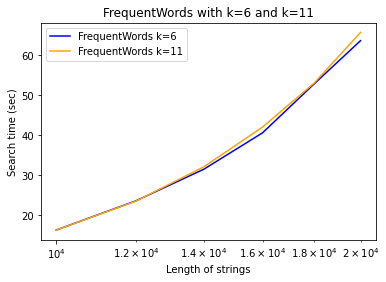

In [8]:
plt.title('FrequentWords with k=6 and k=11')
plt.xlabel('Length of strings')
plt.ylabel('Search time (sec)')
plt.xscale("log")
plt.plot(lengths, fwstimes, color='blue', label='FrequentWords k=6')
plt.plot(lengths, fwtimes, color='orange', label='FrequentWords k=11')
plt.legend()
plt.show()

We notice that going from $k=6$ to $k=11$ there are no significant changes in time.

### Experiment No. 2 : $k$-mers optimized search, using FrequentWordsDict.

#### In this experiment we have created a dictionary for indexing $k$-mers and a list for storing their respective frequencies in order to optimize the search, keeping their counts and measuring the search time.

#### This proceedure requires $\mathcal{O}(n)$ time, which makes it faster than the previous seach proceedure.

#### However, in order to achieve these optimizations, we need to create all $n^k$ $k$-mers (with characters from a dictionary with size $n$). In our case, $n=4 \Rightarrow 4^k k$-mers.

Let's define some functions for dictionary creation to index $4^k$ $k$-mers.

<b>getAllKLength</b> creates a dictionary with all possible $k$-mers based on the alphabet.

<b>getAllKLengthRec</b> collects all patterns with length $k$ based on the alphabet.

In [9]:
# A method that creates all possible strings of length k for a given alphabet and stores them in a dictionary.
# The dictionary has these strings as keys and their numeric representation as values, which can be used for indexing.
# It is mainly a wrapper over the recursive function getAllKLengthRec()
def getAllKLength(k, alphabet='ACGT'):
    dictionary = {}
    n = len(alphabet)
    getAllKLengthRec("", dictionary, n, k, alphabet)
    
    return dictionary

# The main recursive method to get all possible strings of length k
def getAllKLengthRec(prefix, dictionary, n, k, alphabet):
    # Base case: k is 0, store prefix and index in the dictionary
    if (k == 0):
        dictionary[prefix] = len(dictionary)
        return

    # One by one add all characters from alphabet and recursively
    # call for new k_new = k_old - 1
    for i in range(n):
        # Next character of input added 
        newPrefix = prefix + alphabet[i]

        # k decreases, because we have added a new character
        getAllKLengthRec(newPrefix, dictionary, n, k - 1, alphabet)

Let's define some functions for $k$-mers search using multiprocessing.

<b>FrequentWordsDict</b> creates a list for word frequency counts, counts the frequency of all $k$-mers and returns the ones with the highest count.

<b>find_patterns_fwd</b> reads string from a file and initializes the search, counting the respective durations.

<b>run_multiprocessing_fwd</b> initializes multiprocessing.

In [10]:
def FrequentWordsDict(text, k, alphabet, dictionary):
    frequent_patterns = set()
    text_length = len(text)
    num_chars = len(alphabet)
    
    # a (frequency) array of length 4^k
    farray = np.zeros(num_chars ** k)
    
    # calcuate word frequency
    for i in range(0, text_length-k+1):
        pattern = text[i:i+k]
        index = dictionary[pattern]
        farray[index] += 1
    
    # maximum frequency
    max_count = max(farray)
    
    # add words with maximum frequency to frequent_patterns
    for i in range(0, text_length-k+1):
        pattern = text[i:i+k]
        index = dictionary[pattern]
        if farray[index] == max_count:
            frequent_patterns.add(text[i:i+k])
    
    return (frequent_patterns, max_count)

# function to be executed by each process
def find_patterns_fwd(length, filename, k, alphabet):
    logging.info(f"Process {length}: starting")
    
    # index of 4^k k-mers
    dictionary = getAllKLength(k, alphabet)
    
    time = 0
    words = []
    
    count = 0
    
    file = open(filename, 'r')

    for line in file:
        text = line.strip()
        
        if len(text) != length:
            continue
        
        start=timeit.default_timer()
        result = FrequentWordsDict(text,k,alphabet,dictionary)
        stop=timeit.default_timer()
        time += stop-start
        words.append(result)
        
        count += 1

    file.close()
    
    logging.info(f"Process {length}: finishing")
    
    return (time/count, words)

# mutliprocessing intitialization
def run_multiprocessing_fwd(func, lengths, filename, k, alphabet, n_processes):
    with Pool(processes=n_processes) as pool:
        return pool.map(partial(func, filename=filename, k=k, alphabet=alphabet), lengths)

#### Now, we are going to search for $11$-mers in the random strings, using FrequentWordsDict.

The dictionary for $k$-mer frequency indexing all $4^k$ $k$-mers as well as the frequency list, require a significant amount of memory as the value of $k$ raises. Furthermore, since we use multiprocessing, every process will have its own copy of these data structures, which raises the memory requirements even further. This means we must be careful regarding the values of $k$ we are going to use.

For example, using $k > 11$ results in the creation of at least $4^{12}\approx16,800,000$ different $12$-mers for indexing, each one with size about 61 bytes, which translates to $4^{12}\times61\approx1.1$ GB for every single process. With $6$ processes we end up with memory usage of $\approx6.2$ GB.

In [11]:
k = 11

# multiprocessing
outputs = run_multiprocessing_fwd(find_patterns_fwd, lengths, filename, k, alphabet, n_processes)


# collect the appropriate outputs for presentation
fwdtimes = []
fwdwords = []

for output in outputs:
    fwdtimes.append(output[0])
    fwdwords.append(output[1])


# present outputs
print(f"FrequentWordsDict time (seconds): {sum(fwdtimes)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWordsDict:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwdwords[i][j][0])} {k}-mers of frequency {fwdwords[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")

17:13:21: Process 14000: starting17:13:21: Process 12000: starting17:13:21: Process 18000: starting

17:13:21: Process 10000: starting
17:13:21: Process 16000: starting17:13:21: Process 20000: starting


17:13:28: Process 10000: finishing
17:13:28: Process 16000: finishing
17:13:28: Process 14000: finishing
17:13:28: Process 18000: finishing
17:13:28: Process 20000: finishing
17:13:28: Process 12000: finishing


FrequentWordsDict time (seconds): 3.972131391288713
----------------------------------------------------------------------------------------------------
Top 11-mers using FrequentWordsDict:
14 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
6 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
13 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
20 11-mers of frequency 2.0 in 1 of 3 strings of length 12000
17 11-mers of frequency 2.0 in 1 of 3 strings of length 12000
1 11-mers of frequency 3.0 in 1 of 3 strings of length 12000
24 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
25 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
32 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
35 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
27 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
24 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
39 11-mers of frequency 2.0 in 1 of 3 strings of length 18000
55 11-

#### Results

Let's plot the time difference between using FrequentWords and FrequentWordsDict in searching for $11$-mers.

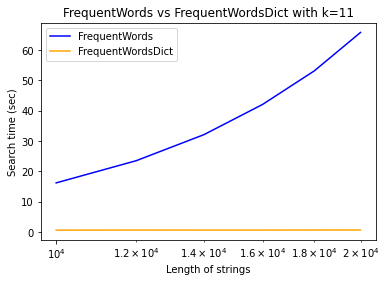

In [12]:
plt.title('FrequentWords vs FrequentWordsDict with k=11')
plt.xlabel('Length of strings')
plt.ylabel('Search time (sec)')
plt.xscale("log")
plt.plot(lengths, fwtimes, color='blue', label='FrequentWords')
plt.plot(lengths, fwdtimes, color='orange', label='FrequentWordsDict')
plt.legend()
plt.show()

It is obvious that while using FrequentWords the search time increases exponentially, while using FrequentWordsDict the search time was barely increses with the length of strings.

### Experiment No. 3 : $k$-mers optimized search, using FrequentWordsDictNew.

#### To avoid creating the dictionary with the $4^{k}$ patterns, we can convert each pattern to its respective occurence number for indexing. The first time a pattern occurs among all patterns, this becomes its respective index number. We then add it to the dictionary to avoid future conversions of the same $k$-mer.

#### This helps in saving memory and avoiding out-of-memory situation, since we only index patterns that do exist in the strings we examine. On the other hand we get an increase in search times, since we need to convert every $k$-mer to number the first time we come across it. We use this dictionary to help us with updating the respective frequency of every $k$-mer in the farray which is a list.

Let's define a function for converting each pattern to its respective index number.

<b>PatternToNumber</b> converts each pattern to its respective index number.

In [13]:
def PatternToNumber(pattern, k, alphabet='ACGT'):
    if len(pattern) != k:
        print("String length does not match the value of k")
        raise
    
    # Convert alphabet to enumerated dictionary
    dictionary = dict((j,i) for i,j in enumerate(list(alphabet)))
    
    # Find the character with zero value in the dictionary
    zero = ''
    for key, value in dictionary.items():
        if value == 0:
            zero = key
            break
    
    # Remove redundant "zeros" from the beggining of the pattern
    newpattern = ''
    for index in range(len(pattern)):
        if pattern[index] != zero:
            newpattern = pattern[index:]
            break
    
    # Find the index of pattern (construct like converting from a system of 4 digits to decimal)
    number = 0
    conversion_base = len(dictionary)
    for index, char in enumerate(reversed(newpattern)):
        number += dictionary[char] * (conversion_base ** index)
    
    return number

Let's define some functions for $k$-mers search using multiprocessing.

<b>FrequentWordsDictNew</b> creates a list for word frequency counts, counts the frequency of all $k$-mers and returns the ones with the highest count.

<b>find_patterns_fdwn</b> reads string from a file and initializes the search, counting the respective durations.

<b>run_multiprocessing_fwdn</b> initializes multiprocessing.

In [14]:
def FrequentWordsDictNew(text, k, alphabet):
    frequent_patterns = set()
    text_length = len(text)
    num_chars = len(alphabet)
    
    # empty dictionary, will be filled only with found words
    dictionary = dict()
    
    # a (frequency) array of length 4^k
    farray = np.zeros(num_chars ** k)
    
    # calcuate word frequency
    for i in range(0, text_length-k+1):
        pattern = text[i:i+k]
        
        if pattern in dictionary:
            # pattern already processed
            index = dictionary[pattern]
            farray[index] += 1
        else:
            # new pattern
            index = PatternToNumber(pattern, k)
            dictionary[pattern] = index
            farray[index] = 1
    
    # maximum frequency
    max_count = max(farray)
    
    # add words with maximum frequency to frequent_patterns
    for i in range(0, text_length-k+1):
        pattern = text[i:i+k]
        index = dictionary[pattern]
        if farray[index] == max_count:
            frequent_patterns.add(text[i:i+k])
    
    return (frequent_patterns,max_count)

# function to be executed by each process
def find_patterns_fdwn(length, filename, k, alphabet):
    logging.info(f"Process {length}: starting")
    
    time = 0
    words = []
    
    count = 0
    
    file = open(filename, 'r')

    for line in file:
        text = line.strip()
        
        if len(text) != length:
            continue

        start=timeit.default_timer()
        result = FrequentWordsDictNew(text,k,alphabet)
        stop=timeit.default_timer()
        time += stop-start
        words.append(result)
        
        count += 1

    file.close()
    
    logging.info(f"Process {length}: finishing")
    
    return (time/count, words)

# mutliprocessing intitialization
def run_multiprocessing_fwdn(func, lengths, filename, k, alphabet, n_processes):
    with Pool(processes=n_processes) as pool:
        return pool.map(partial(func, filename=filename, k=k, alphabet=alphabet), lengths)

#### Now, we are going to search for $11$-mers in the random strings, using FrequentWordsDictNew.

In [15]:
k = 11


# multiprocessing
outputs = run_multiprocessing_fwdn(find_patterns_fdwn, lengths, filename, k, alphabet, n_processes)


# collect the appropriate outputs for presentation
fwdntimes = []
fwdnwords = []

for output in outputs:
    fwdntimes.append(output[0])
    fwdnwords.append(output[1])


# present outputs
print(f"FrequentWordsDictNew time (seconds): {sum(fwdntimes)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWordsDictNew:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwdnwords[i][j][0])} {k}-mers of frequency {fwdnwords[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")

17:13:29: Process 12000: starting17:13:29: Process 10000: starting17:13:29: Process 14000: starting17:13:29: Process 16000: starting17:13:29: Process 20000: starting17:13:29: Process 18000: starting





17:13:31: Process 12000: finishing
17:13:32: Process 14000: finishing
17:13:32: Process 16000: finishing
17:13:32: Process 20000: finishing
17:13:34: Process 10000: finishing
17:13:34: Process 18000: finishing


FrequentWordsDictNew time (seconds): 6.3198488993414985
----------------------------------------------------------------------------------------------------
Top 11-mers using FrequentWordsDictNew:
14 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
6 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
13 11-mers of frequency 2.0 in 1 of 3 strings of length 10000
20 11-mers of frequency 2.0 in 1 of 3 strings of length 12000
17 11-mers of frequency 2.0 in 1 of 3 strings of length 12000
1 11-mers of frequency 3.0 in 1 of 3 strings of length 12000
24 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
25 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
32 11-mers of frequency 2.0 in 1 of 3 strings of length 14000
35 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
27 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
24 11-mers of frequency 2.0 in 1 of 3 strings of length 16000
39 11-mers of frequency 2.0 in 1 of 3 strings of length 18000

#### Results

Let's plot the time difference between using FrequentWordsDict and FrequentWordsDictNew in searching for $11$-mers.

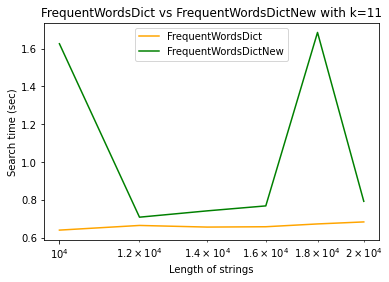

In [16]:
plt.title('FrequentWordsDict vs FrequentWordsDictNew with k=11')
plt.xlabel('Length of strings')
plt.ylabel('Search time (sec)')
plt.xscale("log")
plt.plot(lengths, fwdtimes, color='orange', label='FrequentWordsDict')
plt.plot(lengths, fwdntimes, color='green', label='FrequentWordsDictNew')
plt.legend()
plt.show()

It is obvious that using FrequentWordsDictNew the search time can be slightly higher compared to using FrequentWordsDict. So, the lower memory usage comes at the cost of speed.

The questing now is: can we do better than both FrequentWordsDict and FrequentWordsDictNew? Can we have both lower memory utilization and higher speed?

### Experiment No. 4 : $k$-mers optimized search, using FrequentWordsDictImproved.

#### We are going to utilize a dictionary with default values for counting the occurencies of the patterns that exist in the strings we examine, instead of a maintaining a separate list, with the help of Python's collections.defaultdict.

Let's define some functions for $k$-mers search using multiprocessing.

<b>FrequentWordsDictImproved</b> creates a dictionary for word frequency counts, counts the frequency of all $k$-mers and returns the ones with the highest count.

<b>find_patterns_fdwi</b> reads string from a file and initializes the search, counting the respective durations.

<b>run_multiprocessing_fwdi</b> initializes multiprocessing.

In [17]:
from collections import defaultdict

def FrequentWordsDictImproved(text, k):
    frequent_patterns = set()
    text_length = len(text)
    
    # empty dictionary with default values 0, will be filled only with found words
    patterns = defaultdict(int)
    
    # calcuate word frequency
    for i in range(0, text_length-k+1):
        pattern = text[i:i+k]
        patterns[pattern] += 1
    
    # maximum frequency
    max_count = max(patterns.values())
    
    # add words with maximum frequency to frequent_patterns
    for key, value in patterns.items():
        if value == max_count:
            frequent_patterns.add(key)
    
    return(frequent_patterns,max_count)

# function to be executed by each process
def find_patterns_fdwi(length, filename, k):
    logging.info(f"Process {length}: starting")
    
    time = 0
    words = []
    
    count = 0
    
    file = open(filename, 'r')

    for line in file:
        text = line.strip()
        
        if len(text) != length:
            continue

        start=timeit.default_timer()
        result = FrequentWordsDictImproved(text,k)
        stop=timeit.default_timer()
        time += stop-start
        words.append(result)
        
        count += 1

    file.close()
    
    logging.info(f"Process {length}: finishing")
    
    return (time/count, words)

# mutliprocessing intitialization
def run_multiprocessing_fwdi(func, lengths, filename, k, n_processes):
    with Pool(processes=n_processes) as pool:
        return pool.map(partial(func, filename=filename, k=k), lengths)

#### Now, we are going to search for $11$-mers in the random strings, using FrequentWordsDictImproved.

In [18]:
k = 11


# multiprocessing
outputs = run_multiprocessing_fwdi(find_patterns_fdwi, lengths, filename, k, n_processes)


# collect the appropriate outputs for presentation
fwditimes = []
fwdiwords = []

for output in outputs:
    fwditimes.append(output[0])
    fwdiwords.append(output[1])


# present outputs
print(f"FrequentWordsDictImproved time (seconds): {sum(fwditimes)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWordsDictImproved:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwdiwords[i][j][0])} {k}-mers of frequency {fwdiwords[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")

17:13:35: Process 10000: starting17:13:35: Process 14000: starting17:13:35: Process 20000: starting17:13:35: Process 18000: starting17:13:35: Process 16000: starting
17:13:35: Process 12000: starting




17:13:35: Process 18000: finishing
17:13:35: Process 20000: finishing
17:13:35: Process 12000: finishing
17:13:35: Process 14000: finishing
17:13:35: Process 16000: finishing17:13:35: Process 10000: finishing



FrequentWordsDictImproved time (seconds): 0.08125300856772812
----------------------------------------------------------------------------------------------------
Top 11-mers using FrequentWordsDictImproved:
14 11-mers of frequency 2 in 1 of 3 strings of length 10000
6 11-mers of frequency 2 in 1 of 3 strings of length 10000
13 11-mers of frequency 2 in 1 of 3 strings of length 10000
20 11-mers of frequency 2 in 1 of 3 strings of length 12000
17 11-mers of frequency 2 in 1 of 3 strings of length 12000
1 11-mers of frequency 3 in 1 of 3 strings of length 12000
24 11-mers of frequency 2 in 1 of 3 strings of length 14000
25 11-mers of frequency 2 in 1 of 3 strings of length 14000
32 11-mers of frequency 2 in 1 of 3 strings of length 14000
35 11-mers of frequency 2 in 1 of 3 strings of length 16000
27 11-mers of frequency 2 in 1 of 3 strings of length 16000
24 11-mers of frequency 2 in 1 of 3 strings of length 16000
39 11-mers of frequency 2 in 1 of 3 strings of length 18000
55 11-mers of 

#### Results

Let's plot the time difference between using FrequentWordsDictNew and FrequentWordsDictImproved in searching for $11$-mers.

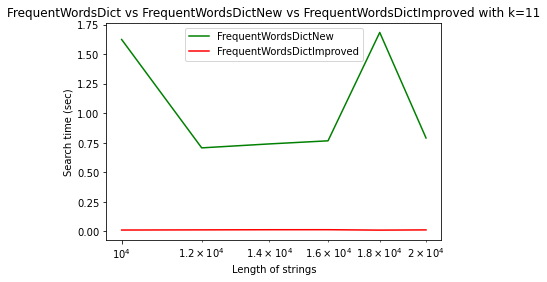

In [19]:
plt.title('FrequentWordsDict vs FrequentWordsDictNew vs FrequentWordsDictImproved with k=11')
plt.xlabel('Length of strings')
plt.ylabel('Search time (sec)')
plt.xscale("log")
plt.plot(lengths, fwdntimes, color='green', label='FrequentWordsDictNew')
plt.plot(lengths, fwditimes, color='red', label='FrequentWordsDictImproved')
plt.legend()
plt.show()

Let's plot the time difference between using any of the 4 methods in searching for $11$-mers.

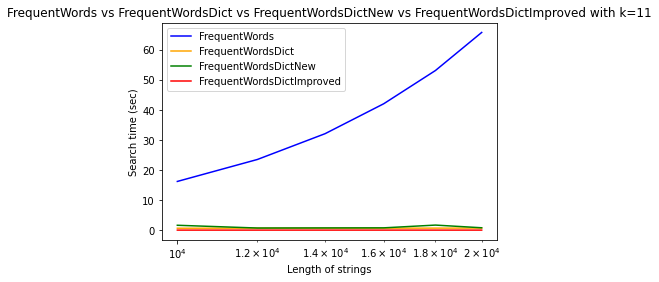

In [20]:
plt.title('FrequentWords vs FrequentWordsDict vs FrequentWordsDictNew vs FrequentWordsDictImproved with k=11')
plt.xlabel('Length of strings')
plt.ylabel('Search time (sec)')
plt.xscale("log")
plt.plot(lengths, fwtimes, color='blue', label='FrequentWords')
plt.plot(lengths, fwdtimes, color='orange', label='FrequentWordsDict')
plt.plot(lengths, fwdntimes, color='green', label='FrequentWordsDictNew')
plt.plot(lengths, fwditimes, color='red', label='FrequentWordsDictImproved')
plt.legend()
plt.show()

We can see that all dict-based search methods are significantly higher than the original method, and the time  differences between them are negligible.

#### Confirm that the search results are correct (that we have found the same words and frequencies independently of the method used)

In [21]:
maxlen = max(len(fwwords), len(fwdwords), len(fwdnwords), len(fwdiwords))

if len(fwwords) != maxlen or len(fwdwords) != maxlen or len(fwdnwords) != maxlen or len(fwdiwords) != maxlen:
    print("Incorrect results: different number of results from different search methods")
else:
    for i in range(len(lengths)):
        words = fwwords[i]
        dwords = fwdwords[i]
        dwnwords = fwdnwords[i]
        dwiwords = fwdiwords[i]
        
        maxlen1 = max(len(words), len(dwords), len(dwnwords), len(dwiwords))
        
        if len(words) != maxlen1 or len(dwords) != maxlen1 or len(dwnwords) != maxlen1 or len(dwiwords) != maxlen1:
            print(f"Incorrect results: different number results from different search methods for length {lengths[i]}")
            break
        
        for j in range(maxlen1):
            w = words[j]
            dw = dwords[j]
            dnw = dwnwords[j]
            diw = dwiwords[j]
            
            if not set.intersection(set(w[0]), set(dw[0]), set(dnw[0]), set(diw[0])):
                print(f"Incorrect results: different most frequent words for length {lengths[i]} in string number {j}")
                break
            
            maxc = max(w[1], dw[1], dnw[1], diw[1])
            
            if w[1] != maxc or dw[1] != maxc or dnw[1] != maxc or diw[1] != maxc:
                print(f"Incorrect results: different count of most frequent words for length {lengths[i]} in string number {j}")
                break

### Proof that FrequentWordsDictImproved is better

#### On some of the machines we tested this notebook, we noticed that with FrequentWordsDict using $k>11$ resulted in multiprocessing execution hanging indefinitely.

#### With FrequentWordsDictNew we could go up to $k=13$ safely, while using $k\geqslant13$ multiprocessing execution hanged indefinitely.

To make the halt problem obvious, just change the number of $k$ on the first line in the following cell and run it. You will notice that based on the specification of the machine, the execution will halt after some value of $k$ and interrupting the kernel using the stop button may not have any result.

In [22]:
k = 13


outputs = run_multiprocessing_fwdn(find_patterns_fdwn, lengths, filename, k, alphabet, n_processes)

fwdn2times = []
fwdn2words = []

for output in outputs:
    fwdn2times.append(output[0])
    fwdn2words.append(output[1])

print(f"FrequentWordsDictNew time (seconds): {sum(fwdn2times)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWordsDictNew:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwdn2words[i][j][0])} {k}-mers of frequency {fwdn2words[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")


print('-' * 100)
print('-' * 100)
print('-' * 100)


outputs = run_multiprocessing_fwdi(find_patterns_fdwi, lengths, filename, k, n_processes)

fwdi2times = []
fwdi2words = []

for output in outputs:
    fwdi2times.append(output[0])
    fwdi2words.append(output[1])

print(f"FrequentWordsDictImproved time (seconds): {sum(fwdi2times)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWordsDictImproved:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwdi2words[i][j][0])} {k}-mers of frequency {fwdi2words[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")

17:13:37: Process 16000: starting17:13:37: Process 10000: starting17:13:37: Process 14000: starting17:13:37: Process 18000: starting17:13:37: Process 12000: starting17:13:37: Process 20000: starting




17:14:03: Process 10000: finishing
17:14:03: Process 12000: finishing
17:14:03: Process 16000: finishing
17:14:04: Process 18000: finishing
17:14:04: Process 14000: finishing
17:14:04: Process 20000: finishing


FrequentWordsDictNew time (seconds): 54.08824593934696
----------------------------------------------------------------------------------------------------
Top 13-mers using FrequentWordsDictNew:
1 13-mers of frequency 2.0 in 1 of 3 strings of length 10000
9988 13-mers of frequency 1.0 in 1 of 3 strings of length 10000
9988 13-mers of frequency 1.0 in 1 of 3 strings of length 10000
4 13-mers of frequency 2.0 in 1 of 3 strings of length 12000
11988 13-mers of frequency 1.0 in 1 of 3 strings of length 12000
11988 13-mers of frequency 1.0 in 1 of 3 strings of length 12000
1 13-mers of frequency 2.0 in 1 of 3 strings of length 14000
2 13-mers of frequency 2.0 in 1 of 3 strings of length 14000
3 13-mers of frequency 2.0 in 1 of 3 strings of length 14000
3 13-mers of frequency 2.0 in 1 of 3 strings of length 16000
15988 13-mers of frequency 1.0 in 1 of 3 strings of length 16000
15988 13-mers of frequency 1.0 in 1 of 3 strings of length 16000
2 13-mers of frequency 2.0 in 1 of 3 strings of le

17:14:05: Process 12000: starting17:14:05: Process 16000: starting

17:14:05: Process 10000: starting17:14:05: Process 20000: starting17:14:05: Process 14000: starting17:14:05: Process 18000: starting



17:14:05: Process 12000: finishing
17:14:05: Process 10000: finishing
17:14:05: Process 16000: finishing
17:14:05: Process 14000: finishing17:14:05: Process 20000: finishing

17:14:05: Process 18000: finishing


FrequentWordsDictImproved time (seconds): 0.10682242169665793
----------------------------------------------------------------------------------------------------
Top 13-mers using FrequentWordsDictImproved:
1 13-mers of frequency 2 in 1 of 3 strings of length 10000
9988 13-mers of frequency 1 in 1 of 3 strings of length 10000
9988 13-mers of frequency 1 in 1 of 3 strings of length 10000
4 13-mers of frequency 2 in 1 of 3 strings of length 12000
11988 13-mers of frequency 1 in 1 of 3 strings of length 12000
11988 13-mers of frequency 1 in 1 of 3 strings of length 12000
1 13-mers of frequency 2 in 1 of 3 strings of length 14000
2 13-mers of frequency 2 in 1 of 3 strings of length 14000
3 13-mers of frequency 2 in 1 of 3 strings of length 14000
3 13-mers of frequency 2 in 1 of 3 strings of length 16000
15988 13-mers of frequency 1 in 1 of 3 strings of length 16000
15988 13-mers of frequency 1 in 1 of 3 strings of length 16000
2 13-mers of frequency 2 in 1 of 3 strings of length 18000
8 1

#### Results

Let's plot the time difference between using FrequentWordsDictNew and FrequentWordsDictImproved in searching for $13$-mers.

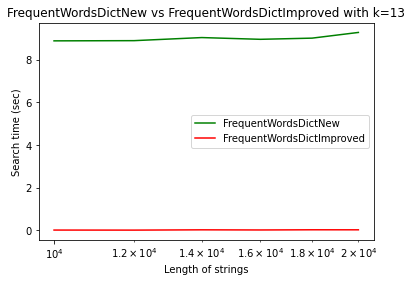

In [23]:
plt.title('FrequentWordsDictNew vs FrequentWordsDictImproved with k=13')
plt.xlabel('Length of strings')
plt.ylabel('Search time (sec)')
plt.xscale("log")
plt.plot(lengths, fwdn2times, color='green', label='FrequentWordsDictNew')
plt.plot(lengths, fwdi2times, color='red', label='FrequentWordsDictImproved')
plt.legend()
plt.show()

#### With FrequentWordsDictImproved we can safely go to $k>13$ without hitting an execution problem.

We tested values of $k$ up to $k=100$.

In [24]:
k = 100


outputs = run_multiprocessing_fwdi(find_patterns_fdwi, lengths, filename, k, n_processes)

fwdi3times = []
fwdi3words = []

for output in outputs:
    fwdi3times.append(output[0])
    fwdi3words.append(output[1])

print(f"FrequentWordsDictImproved time (seconds): {sum(fwdi3times)}")

print('-' * 100)

print(f"Top {k}-mers using FrequentWordsDictImproved:")
for i in range(len(lengths)):
    for j in range(maxStringsPerLength):
        print(f"{len(fwdi3words[i][j][0])} {k}-mers of frequency {fwdi3words[i][j][1]} in 1 of {maxStringsPerLength} strings of length {lengths[i]}")

17:14:05: Process 10000: starting17:14:05: Process 12000: starting17:14:05: Process 14000: starting17:14:05: Process 18000: starting
17:14:05: Process 16000: starting17:14:05: Process 20000: starting




17:14:05: Process 10000: finishing
17:14:05: Process 12000: finishing
17:14:05: Process 14000: finishing
17:14:05: Process 18000: finishing
17:14:05: Process 16000: finishing
17:14:05: Process 20000: finishing


FrequentWordsDictImproved time (seconds): 0.14486192465604594
----------------------------------------------------------------------------------------------------
Top 100-mers using FrequentWordsDictImproved:
9901 100-mers of frequency 1 in 1 of 3 strings of length 10000
9901 100-mers of frequency 1 in 1 of 3 strings of length 10000
9901 100-mers of frequency 1 in 1 of 3 strings of length 10000
11901 100-mers of frequency 1 in 1 of 3 strings of length 12000
11901 100-mers of frequency 1 in 1 of 3 strings of length 12000
11901 100-mers of frequency 1 in 1 of 3 strings of length 12000
13901 100-mers of frequency 1 in 1 of 3 strings of length 14000
13901 100-mers of frequency 1 in 1 of 3 strings of length 14000
13901 100-mers of frequency 1 in 1 of 3 strings of length 14000
15901 100-mers of frequency 1 in 1 of 3 strings of length 16000
15901 100-mers of frequency 1 in 1 of 3 strings of length 16000
15901 100-mers of frequency 1 in 1 of 3 strings of length 16000
17901 100-mers of frequenc

#### Results

Let's plot the time difference between using FrequentWordsDictNew in searching for $13$-mers and FrequentWordsDictImproved in searching for $100$-mers.

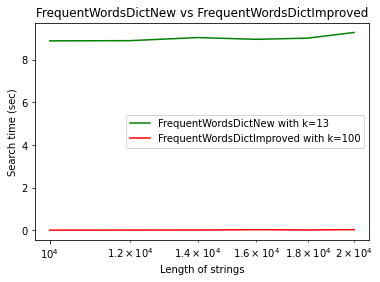

In [25]:
plt.title('FrequentWordsDictNew vs FrequentWordsDictImproved')
plt.xlabel('Length of strings')
plt.ylabel('Search time (sec)')
plt.xscale("log")
plt.plot(lengths, fwdn2times, color='green', label='FrequentWordsDictNew with k=13')
plt.plot(lengths, fwdi3times, color='red', label='FrequentWordsDictImproved with k=100')
plt.legend()
plt.show()

## Part 2: Avoid generating $4^k$ $k$-mers
### Consider the problem "find all most frequent $k$-mers with up to d mismatches in a DNA string" as presented in lecture L3. Give ideas to avoid generating $4^k$ $k$-mers.

#### Given a found $k$-mer in a DNA string, we can generate its $(k,d)$-neighbors. Each $(k,d)$-neighbor is a $k$-mer with $d$ mismatches compared to the original $k$-mer.
#### Using this method, we can create all ${k \choose 1} + {k \choose 2} + ... + {k \choose d}$ $(k,d)$-neighbors with up to $d$ mismatches for every original $k$-mer we find in a DNA string.
#### ${k \choose 1} + {k \choose 2} + {}  ... {} + {k \choose d} {} < {} {d}\cdot{k \choose d} {} < {} d\cdot{k^d} {} = {} O(d\cdot{k^d})$ which for "small" values of $k$ and $d$ is signicifanctly smaller than $4^k$.
#### Also, since we examine DNA strings which are not really random strings, as a DNA string is a unique characterstic of a living organism, this means that some $k$-mers will reappear within the string and that we will get the same $(k,d)$-neighbors for different $k$-mers with high resemblence. So, the total number of $k$-mers generated will be really a fraction of $4^k$.